__Algorithm to determine if a data point is within a polygon:__
1. Find line segment equation from data point to NW coordinate
2. Find line segment equations for all boundary points
3. Calculate intersection point for each line and check if it is between the points of both line segments
4. Return 1 (intersection in line segment) or 0 (no intersection in line segment)
5. Add together all intersection values returned:
    - A total odd number means the line is within the polygon
    - A total even number mean the line is outside of the polygon

In [1]:
from PIL import Image
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output, display
from dataclasses import dataclass

### For KMZ Parsing
from os import path
import math
from zipfile import ZipFile
import xml.sax, xml.sax.handler

In [2]:
coord = namedtuple('coord','lat lon')
linEQ = namedtuple('linEQ','m b')

In [3]:
class MapObject:
    def __init__(self, image_file):
        self.image = image_file
        self.Open()
        
    def Open(self):
        self.im = Image.open(self.image)
        self.dlat = self.im.tag[33550][0]
        self.dlon = self.im.tag[33550][1]
        self.size = np.array([self.im.tag[256][0], self.im.tag[257][0]])
        self.NW = coord(lat=self.im.tag[33922][4], lon=self.im.tag[33922][3])
        self.SE = coord(lat=self.NW.lat-self.dlat*self.size[0], lon=self.NW.lon+self.dlon*self.size[1])
        self.array = np.array(self.im)
        self.test = coord(lat=None, lon=None)
        
    
    def delta(self, coords):
        ### the argument 'coords' must be a namedtuple instance of coord

        ### make sure the coordinate is the right type:
        if type(coords) is not type(self.test):
            raise Exception('coords is of the wrong type! must be coord namedtuple.')

        ### calculate the index of the matrix for the desired location
        n_lat = int(abs((coords.lat-self.NW.lat)/self.dlat))
        n_lon = int(abs((coords.lon-self.NW.lon)/self.dlon))
        return (n_lat, n_lon)
    
    
    def elevation(self,coords):
        ### the argument 'coords' must be a namedtuple instance of coord

        ### get the indicies of the array that correspond to the lat/lon of coordinates
        n_lat, n_lon = self.delta(coords)

        ### Check to make sure that n_lat and n_lon are within the range of the array
        if n_lat not in range(self.size[0]) or n_lon not in range(self.size[1]):
            raise Exception(f'{n_lat} or {n_lon} Not in Range!!')

        return self.array[n_lat][n_lon]


## Parse the data from a google earth KMZ file

__Create a path in Google Earth of the desired boundary. Load the resulting KMZ file__

(Right Click Path, Save place as...)

~~Do not close path loop! Leave last path that would close the path loop off of Google Earth!~~

[Source for KMZ Parsing Code](http://programmingadvent.blogspot.com/2013/06/kmzkml-file-parsing-with-python.html)

In [4]:
class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""

In [5]:
class KMZ:
    def __init__(self, kmz_file):
        self.file = kmz_file

        with ZipFile(self.file, 'r') as kmz:
            self.kml = kmz.open('doc.kml', 'r')
            parser = xml.sax.make_parser()
            self.handler = PlacemarkHandler()
            parser.setContentHandler(self.handler)
            parser.parse(self.kml)
            
        self.get_coords()
        self.filename = self.get_filename()
            
    def get_coords(self):
        self.fence = [coord(lat=float(coordinate.split(',')[1]), lon=float(coordinate.split(',')[0])) for coordinate in self.handler.mapping[list(self.handler.mapping)[0]]['coordinates'].split()]
        
        ### Prevent the closed loop divide by zero error
        if self.fence[0] == self.fence[-1]:
            del self.fence[-1]
            
    def get_filename(self):
        fname = f'n{math.floor(self.fence[0].lat)}_w{abs(math.floor(self.fence[0].lon))}_1arc_v3.tif'
        if path.exists(fname):
            return fname
        else:
            print(f'File not found. Download {fname} from USGS EarthExplorer!')
            return None
        
    def plot_fence(self):
        plt.plot([i.lon for i in self.fence], [i.lat for i in self.fence])
        plt.show()

In [6]:
class Mountain:
    def __init__(self, mapObject, kmzObject, name=None):
        print('Creating Mountain Object')
        ### The name of the area in the enclosed polygon, if desired
        self.name = name
        ### Objects
        self.mapObject = mapObject
        self.kmzObject = kmzObject
        ### Polygon is a list of coordinates that encloses an area
        self.polygon = self.kmzObject.fence
        ### Close the polygon loop
        self.polygon.append(self.polygon[0])
        clear_output()
        print('Starting setup...')
        self.setup()
        clear_output()
        print('Creating elevation array...')
        self.get_elevation_array()
        clear_output()
        print('Done.')
        
        
    def get_linear_equation(self, pt1, pt2):
        ### Calculate the slope and offset of linear equation that 
        ### connects two points of the form y = mx + b

        ### Slope (m):
        m = (pt2.lon - pt1.lon) / (pt2.lat - pt1.lat)

        ### Offset (b):
        b = pt2.lon - m*pt2.lat

        ### linEQ is a namedtuple to easily reference the slope or offset
        return linEQ(m=m, b=b)
    
    
    def intersection(self, pt1, pt2, pt3, pt4=None):
        ### pt1 is the starting point for the leg of polygon being checked
        ### pt2 is the ending point for the leg of the polygon being checked
        ### pt3 is the coordinate being checked
        ### pt4 the outside reference point. It will default to a point NE 
        ###     of the polygon. Set your own where ever you'd like. 

        if pt4 is None:
            pt4 = coord(lat=max([i.lat for i in self.polygon])+1, lon=max([i.lon for i in self.polygon])+1)

        line1 = self.get_linear_equation(pt1,pt2)
        line2 = self.get_linear_equation(pt3,pt4)

        try:
            x = (line2.b - line1.b) / (line1.m - line2.m)
            y = line2.m * x +line2.b

        except ZeroDivisionError: 
            ### If lines are parallel, a divide by zero error will occur
            return 0

        ### If the point (x,y) is between the endpoints for BOTH of the line segments, they cross. Otherwise, they do not.
        if all([
            min([pt1.lat, pt2.lat]) <= x <= max([pt1.lat, pt2.lat]),
            min([pt3.lat, pt4.lat]) <= x <= max([pt3.lat, pt4.lat]), 
            min([pt1.lon, pt2.lon]) <= y <= max([pt1.lon, pt2.lon]), 
            min([pt3.lon, pt4.lon]) <= y <= max([pt3.lon, pt4.lon])
        ]):
            return 1
        return 0
    
    
    def get_passes(self, loc, ref=None):
        ### passes is the number of times the location-reference line cross through a polygon line.
        ### The argumenr 'loc' is the current coordinate that it being tested (pt3 in self.intersection).
        ### The argument 'ref' is the reference point which will be automatically calculated if left as None. (pt4 in self.intersection)

        ### An odd number means the point is within the polygon
        ### An even number means the point is outside the polygon

        passes = 0
        for num in range(len(self.polygon)-1):
            passes += self.intersection(self.polygon[num],self.polygon[num+1], loc, ref)
        return passes
    
    
    def setup(self):
        self.NW = coord(lat=max([i.lat for i in self.polygon]), lon=min([i.lon for i in self.polygon]))
        self.SE = coord(lat=min([i.lat for i in self.polygon]), lon=max([i.lon for i in self.polygon]))

        ### Calculate the N-S and E-W distances in degrees
        self.delta = abs(np.asarray(self.NW)-np.asarray(self.SE))

        ### The number of values in the upcoming linspaces:
        lon_num, lat_num = self.delta/np.array([self.mapObject.dlon, self.mapObject.dlat])
        self.lat_num = int(lat_num)
        self.lon_num = int(lon_num)

        ### Create a linspace across all longitudes and latitudes
        self.Dlat = np.linspace(self.NW.lat,self.SE.lat,self.lat_num)
        self.Dlon = np.linspace(self.NW.lon,self.SE.lon,self.lon_num)

        ### Find the lat/lon ratios
        self.Ratio = (self.distances(self.SE)*self.delta)
        self.R = self.Ratio/max(self.Ratio)
        self.R2 = np.flip(self.R)
        
        
    def get_elevation_array(self):
        last = 0
        self.elevation_array = np.zeros((self.lon_num, self.lat_num))
        for lat_num, Lat in enumerate(self.Dlat):
            for lon_num, Lon in enumerate(self.Dlon):
                in_poly = self.get_passes(loc=coord(lat=Lat, lon=Lon)) % 2
                self.elevation_array[lon_num, lat_num] = self.mapObject.elevation(coord(lat=Lat, lon=Lon)) if in_poly == 1 else None
            complete = int(round(lat_num/self.lat_num*100,0))
            if complete != last:
                clear_output()
                display(f'Creating elevation array: {complete}% Completed')
            last = complete
                
                
    def show_3D(self, altitude=10, azimuth=80, layers=125, height=12, width=40, save=False, show=True):
        lat_3D, lon_3D = np.meshgrid(self.Dlat, self.Dlon)
        fig = plt.figure(figsize=(width,height))
        ax = plt.axes(projection='3d')
#         ax.set_aspect('equal')
        self.cn = ax.contour3D(lat_3D, lon_3D, self.elevation_array, layers, cmap='binary')
        
        if show:
            ax.set_xlim3d(self.SE.lat, self.NW.lat)
            ax.set_ylim3d(self.SE.lon, self.NW.lon)
            ax.view_init(altitude, azimuth)
            if save:
                plt.savefig('3d_visual.png')
            plt.show()
        else:
            plt.close()
    
        
    def show_2D(self, layers=80, sigma=1):
        self.show_3D(layers=layers, show=False)
        plt.figure(figsize=(12*self.R2))
        plt.ylim(self.SE.lat, self.NW.lat)
        plt.xlim(self.NW.lon, self.SE.lon)
        for array in self.cn.allsegs[1:]:
            for contour in array:
                res = [[ X for X, _ in contour ], [ Y for _, Y in contour ]] 
                plt.plot(gaussian_filter(res[1],sigma=sigma), gaussian_filter(res[0],sigma=sigma),color='green')
        plt.plot([i.lon for i in kmz.fence], [i.lat for i in kmz.fence])
        
        
    def distances(self, coord):
        ### This assumes that latitude is constant over the entire Earth (its not, but varying by 1km wont change a scale by much).
        ### Meters per degree of longitude is calculated by finding the cosine of the latitude angle and multiplying it by equitorial  
        ### longitude distance, which is equal to latitude distance.
        ### The function returns a numpy array of (meters/degree of latitude, meters/degree of longitude).

        lat_dist = 111319.9
        lon_dist = lat_dist * np.cos(np.radians(coord.lat))
        return np.array([lat_dist, lon_dist])
    
    
    def build_contours(self, layers):
        self.show_3D(layers=layers, show=False)
        
        self.contour_data = []
        for array in self.cn.allsegs[1:]:
            d = []
            for contour in array:
                d.append([[X for X, _ in contour ], [Y for _, Y in contour ]])
            self.contour_data.append(d)


In [7]:
def lon_dist(lat):
    ### This assumes that latitude is constant over the entire Earth (its not, but varying by 1km wont change a scale by much).
    ### Meters per degree of longitude is calculated by finding the cosine of the latitude angle and multiplying it by equitorial  
    ### longitude distance, which is equal to latitude distance.
    ### The function returns a numpy array of (meters/degree of latitude, meters/degree of longitude).

    lat_dist = 111319.9
    lon_dist = lat_dist * np.cos(np.radians(lat))
    return lon_dist

## Load a geofence data file

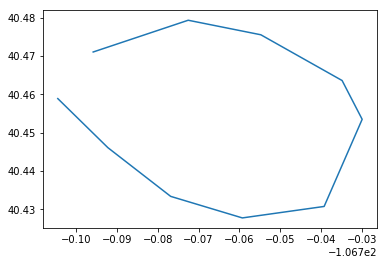

In [28]:
file = 'mtwerner.kmz'
kmz = KMZ(file)
kmz.plot_fence()

## Create a map object of the area within the geofence created above

In [9]:
Map = MapObject(image_file=kmz.filename)

## Create a Mountain object to parse the geofence polygon and create an elevation array

In [10]:
mtn = Mountain(mapObject=Map, kmzObject=kmz)

Done.


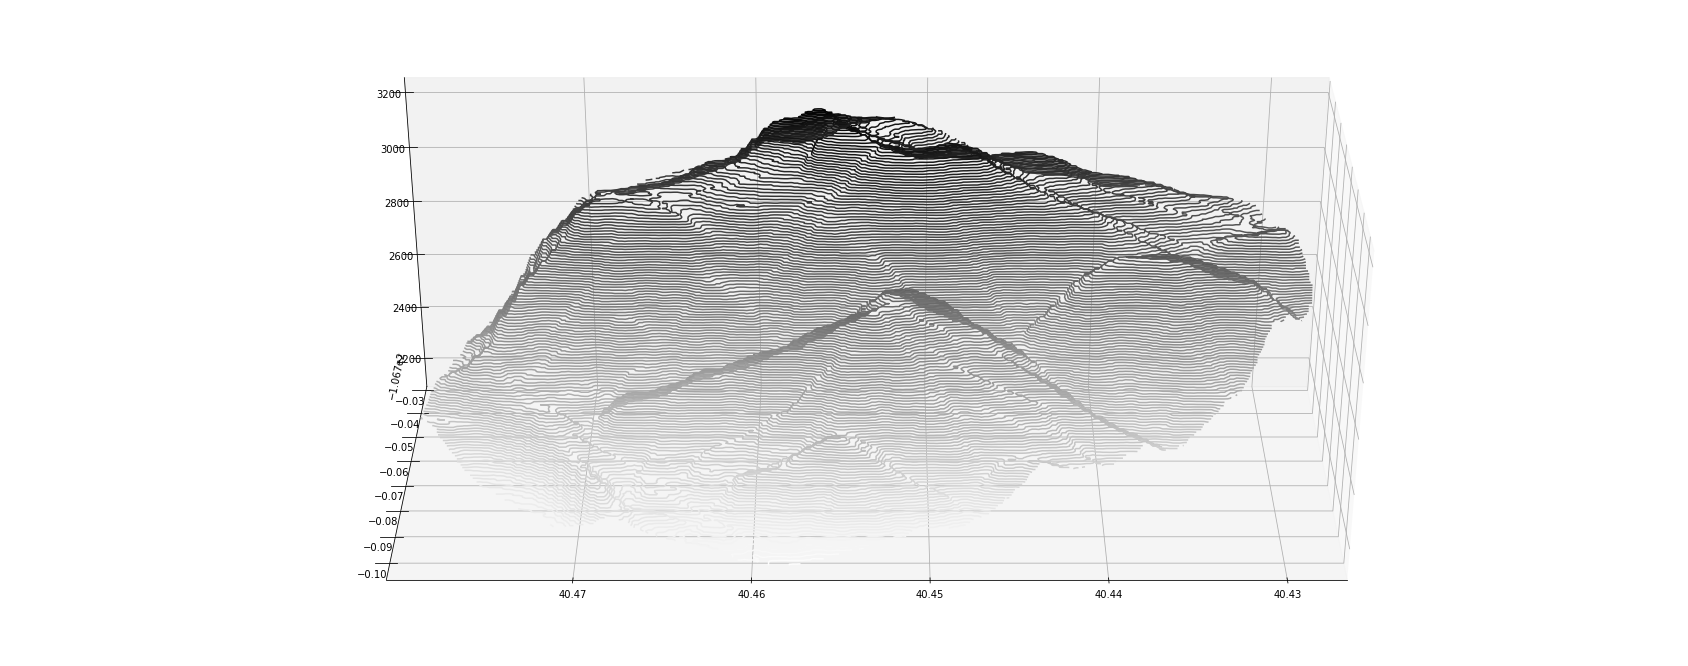

In [11]:
mtn.show_3D(azimuth=90, altitude=30, width=30, height=12, layers=160)

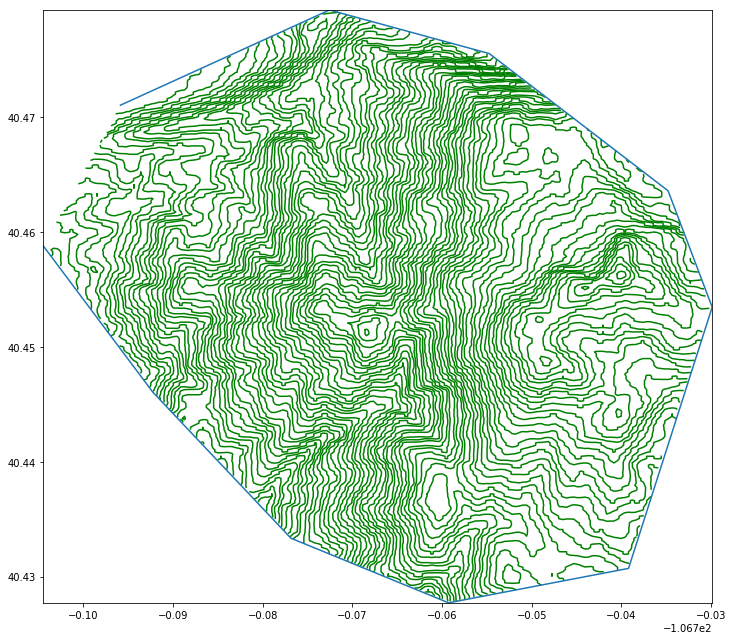

In [36]:
mtn.show_2D(layers=80, sigma=0)

In [15]:
class gCode:
    def __init__(self, mountainObject, kmzObject):
        self.mountainObject = mountainObject
        self.kmzObject = kmzObject
        self.scale = 1
        return
    
            
    def create_unit_model(self, sigma=None):
        cd = list.copy(self.mountainObject.contour_data)
        fu = list.copy(self.kmzObject.fence)
        eq = self.mountainObject.elevation_array

        min_lon = self.mountainObject.NW.lon
        max_lon = self.mountainObject.SE.lon
        min_lat = self.mountainObject.SE.lat
        max_lat = self.mountainObject.NW.lat

        data = {}
        latDist = 111319.9 #m/deg

        ### Calculate mean latitude for longitude distance calculation:
        lats = []
        for layer in cd:
            for Path in layer:
                lats.extend(Path[0])
        ### This is the distance of 1 degree of longitude at a specified latitude
        lonDist = lon_dist(np.mean(lats)) #m/deg

        ratio = ((max_lon-min_lon) * lonDist) if ((max_lon-min_lon) * lonDist) > ((max_lat-min_lat) * latDist) else ((max_lat-min_lat) * latDist)

        fuLat = np.asarray([i.lat for i in fu])
        fuLon = np.asarray([i.lon for i in fu])
        minLat = np.amin(fuLat)
        minLon = np.amin(fuLon)

        for num,layer in enumerate(cd):
            d = []
            for Path in layer:
                lat,lon = Path
                lat = (np.asarray(lat) - minLat) * latDist / ratio
                lon = (np.asarray(lon) - minLon) * lonDist / ratio

                d.append(np.array([lon,lat]))
            data[num] = d

        fuLat = ((fuLat - np.amin(fuLat)) * latDist) / ratio
        fuLon = ((fuLon - np.amin(fuLon)) * lonDist) / ratio

        ### vectorized, scalable model data dictionary:
        self.coord_unit = data
        ### the unit height of the model used for scale calculations (number of layers):
        self.elevation_unit = (np.nanmax(eq) - np.nanmin(eq)) / ratio 
        ### unit fence model:
        self.fence_unit = np.array([fuLat, fuLon])
        ### The number of layers in the current model:
        self.num_layers = num + 1
        ### Add a gaussian filter to smooth the data by adding an integer argument to sigma:
        if isinstance(sigma, int): 
            self.coord_unit = self.smooth_model(self.coord_unit, sigma)
        
        
    def scale_model(self, scale, sigma=None):
        try: self.coord_unit
        except: self.create_unit_model()
        
        self.scale = scale
        self.coord_scaled = {} #scale * self.coord_unit.values()
        for num, layer in enumerate(self.coord_unit.values()):
            d = []
            for Path in layer:
                d.append(scale*Path)#[0],scale*Path[1])
            self.coord_scaled[num] = d
        
        self.fence_scaled = scale * self.fence_unit
    
        self.elevation_scaled = scale * self.elevation_unit
        
        if isinstance(sigma, int): 
            self.coord_scaled = self.smooth_model(self.coord_scaled, sigma)
        
        
    def get_thiccness(self):
        try:
            print(f'Current Scale: {self.scale} mm')
            print(f'Number of Layers in Model: {self.num_layers} layers')
            print(f'Thiccness: {round(self.elevation_scaled / self.num_layers,4)} mm/layer')
            return 
        except: return 'Error! A scaled model has not been created'
        
    def smooth_model(self, dataset, sigma):
        ### Apply a gaussian filter to the scaled model to smooth the lines.
        ### Do not use this function alone, but put a sigma value in create_unit_model
        empty = {}
        for num, block in enumerate(dataset.values()):
            d = []
            for line in block:
                d.append(np.asarray([gaussian_filter(line[0],sigma=sigma), gaussian_filter(line[1],sigma=sigma)]))
            empty[num] = d
        return empty
    
    def show_layers(self):
        ### Plot all layers individually
        try:
            for item in self.coord_scaled.values():
                for line in item:
                    plt.plot(gaussian_filter(line[0],sigma=1), gaussian_filter(line[1],sigma=1), color='green')
                plt.plot(g.fence_scaled[1],g.fence_scaled[0])
                plt.axes().set_aspect('equal', 'datalim')
                plt.show()
                plt.close()
        except:
            print('no scaled model created!')
            
    def calculate_grid_size(self, x, y):
        ### Initialize a grid and number of sheets required for the job
        ### x and y are the size of the material beign cut.
        self.grid = (np.array([x,y])//(self.mountainObject.R2*self.scale))
        self.grid = self.grid.astype(int)
        self.sheets = math.ceil(self.num_layers/np.product(self.grid))
    
    def build_grid(self, x=304, y=304):
        self.calculate_grid_size(x,y)
        Layers = 0
        self.offsets = {}
        for sheet in range(self.sheets):
            d = []
            for Y in range(self.grid[1]):
                for X in range(self.grid[0]):
                    if Layers >= self.num_layers:
                        pass
                    else:
                        d.append((X*self.scale, Y*self.scale))
                    Layers += 1
            self.offsets[sheet] = d

In [16]:
mtn.build_contours(layers=110)

In [17]:
g = gCode(mtn, kmz)
g.create_unit_model()
g.scale_model(scale=60,sigma=0)
g.get_thiccness()

Current Scale: 60 mm
Number of Layers in Model: 76 layers
Thiccness: 0.1398 mm/layer


In [61]:
g.build_grid()

### Generate G-Code from scaled data

In [85]:
passes = 3
lpp = np.product(g.grid)
codes = {}
for pnum, page in g.offsets.items():
    gcode = '''
S0 G21 M8 
G90
G0 F2500
'''

    for onum, offset in enumerate(page):
        layer_num = onum+pnum*lpp
        ### Cut outline
        gcode += 'F1000 S300 M3\n'
        for Pass in range(1):
            for fnum in range(len(g.fence_scaled[0])):
                gcode += f'G{int(bool(fnum))} X{g.fence_scaled[1][fnum] + offset[0]} Y{g.fence_scaled[0][fnum] + offset[1]}\n'
    
#     gcode += 'G4 S10'
    for onum, offset in enumerate(page):
        layer_num = onum+pnum*lpp
        
        ### Add outline of next shape to this shape
        if layer_num +1 == len(g.coord_scaled):
            pass
        else:
            for path in g.coord_scaled[layer_num+1]:
                gcode += 'F1500 S300 M3\n'
                for cnum in range(len(path[0])):
                    gcode += f'G{int(bool(cnum))} X{path[0][cnum] + offset[0]} Y{path[1][cnum] + offset[1]}\n'
        
        ### Cut out the shape
        for path in g.coord_scaled[layer_num]:
            gcode += 'F1000 S1000 M3\n'
            for Pass in range(passes):
                for cnum in range(len(path[0])):
                    gcode += f'G{int(bool(cnum))} X{path[0][cnum] + offset[0]} Y{path[1][cnum] + offset[1]}\n'
        
        ### Cut outline
        gcode += 'F1000 S1000 M4\n'
        for Pass in range(passes):
            for fnum in range(len(g.fence_scaled[0])):
                gcode += f'G{int(bool(fnum))} X{g.fence_scaled[1][fnum] + offset[0]} Y{g.fence_scaled[0][fnum] + offset[1]}\n'
    
    gcode += '''
S0M9M5         ;Laser/Fan OFF
G0 F2500
M2    ;Program End    
'''
    codes[pnum] = gcode


### Generate G-code files

In [86]:
for num in codes:
    with open(f'{kmz.file[:-4]}_{num}.gcode', 'w') as f:
        f.write(codes[num])